In [1]:
import zipfile
zip=zipfile.ZipFile("/content/archive.zip","r")
zip.extractall('/content')
zip.close()

In [2]:
import os
import shutil
import random

# Set the path to your dataset
root_dir = '/content/Multi-version QR codes'  # Update this to your actual dataset path
train_dir = os.path.join(root_dir, 'Train')
test_dir = os.path.join(root_dir, 'Test')

# Function to remove existing directories
def remove_existing_directory(dir_path):
    if os.path.exists(dir_path):
        shutil.rmtree(dir_path)

# Remove existing Train and Test directories if they exist
remove_existing_directory(train_dir)
remove_existing_directory(test_dir)

# Create Train and Test directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Create benign and malicious subdirectories within Train and Test
os.makedirs(os.path.join(train_dir, 'benign'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'malicious'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'benign'), exist_ok=True)
os.makedirs(os.path.join(test_dir, 'malicious'), exist_ok=True)

# Function to copy images to the target folder
def copy_images(source_folder, target_folder, file_list):
    for file in file_list:
        src_path = os.path.join(source_folder, file)
        dst_path = os.path.join(target_folder, file)

        # Only copy if the source and destination are different
        if src_path != dst_path:
            shutil.copy(src_path, dst_path)

# Iterate over each version folder
for version_folder in os.listdir(root_dir):
    version_path = os.path.join(root_dir, version_folder)

    # Ensure it's a directory and not the Train or Test folder
    if os.path.isdir(version_path) and version_folder not in ['Train', 'Test']:
        benign_path = os.path.join(version_path, 'benign')
        malicious_path = os.path.join(version_path, 'malicious')

        print(f"Checking version folder: {version_folder}")  # Debug statement

        # Check if benign and malicious paths exist and are directories
        if os.path.isdir(benign_path) and os.path.isdir(malicious_path):
            print(f"Found benign and malicious folders in: {version_folder}")  # Debug statement

            # Get benign and malicious image lists
            benign_files = os.listdir(benign_path)
            malicious_files = os.listdir(malicious_path)

            # Shuffle files for randomness
            random.shuffle(benign_files)
            random.shuffle(malicious_files)

            # Calculate the number of images for Train and Test splits
            benign_count = len(benign_files)
            malicious_count = len(malicious_files)

            train_benign_count = int(benign_count * 0.8)
            train_malicious_count = int(malicious_count * 0.8)

            # Get Train and Test lists
            train_benign_files = benign_files[:train_benign_count]
            test_benign_files = benign_files[train_benign_count:]

            train_malicious_files = malicious_files[:train_malicious_count]
            test_malicious_files = malicious_files[train_malicious_count:]

            # Copy images to Train folders
            copy_images(benign_path, os.path.join(train_dir, 'benign'), train_benign_files)
            copy_images(malicious_path, os.path.join(train_dir, 'malicious'), train_malicious_files)

            # Copy images to Test folders
            copy_images(benign_path, os.path.join(test_dir, 'benign'), test_benign_files)
            copy_images(malicious_path, os.path.join(test_dir, 'malicious'), test_malicious_files)
        else:
            print(f"Missing benign or malicious folder in: {version_folder}")  # Debug statement

print("Dataset has been reorganized into Train and Test folders.")


Checking version folder: version_2
Found benign and malicious folders in: version_2
Checking version folder: version_10
Found benign and malicious folders in: version_10
Checking version folder: version_1
Found benign and malicious folders in: version_1
Checking version folder: version_40
Found benign and malicious folders in: version_40
Checking version folder: version_3
Found benign and malicious folders in: version_3
Checking version folder: version_30
Found benign and malicious folders in: version_30
Checking version folder: version_20
Found benign and malicious folders in: version_20
Dataset has been reorganized into Train and Test folders.


In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models, utils

from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

from tqdm import tqdm

In [4]:
import os
import pandas as pd

def load_dataset_as_dataframe(data_dir, classes):
    # Print the dataset being loaded from the provided path
    print(f'Loading dataset from: {data_dir}')

    # Create lists to store image paths and labels
    image_paths = []
    labels = []

    # Map class names to labels (based on the given classes list)
    class_to_idx = {class_name: idx for idx, class_name in enumerate(classes)}
    print('Classes:', class_to_idx)

    # Loop over each class directory
    for class_name in classes:
        class_dir = os.path.join(data_dir, class_name)
        label = class_to_idx[class_name]
        # Get all image files in the class directory
        if os.path.exists(class_dir):
            for img_name in os.listdir(class_dir):
                img_path = os.path.join(class_dir, img_name)
                if os.path.isfile(img_path):
                    image_paths.append(img_path)
                    labels.append(label)

    # Create a DataFrame
    data = pd.DataFrame({
        'image_path': image_paths,
        'label': labels
    })

    # Show the distribution of labels in the dataset
    dataset_distribution_dict = {}
    for i in range(len(classes)):
        dataset_distribution_dict[i] = len(data[data['label'] == i])
    print(dataset_distribution_dict)
    print()

    return data

# Specify the classes explicitly
classes = ['benign', 'malicious']

# Specify the paths to the train and test folders
train_folder_path = '/content/Multi-version QR codes/Train'
test_folder_path = '/content/Multi-version QR codes/Test'

# Load train and test datasets
train_df = load_dataset_as_dataframe(train_folder_path, classes)
test_df = load_dataset_as_dataframe(test_folder_path, classes)


Loading dataset from: /content/Multi-version QR codes/Train
Classes: {'benign': 0, 'malicious': 1}
{0: 280, 1: 280}

Loading dataset from: /content/Multi-version QR codes/Test
Classes: {'benign': 0, 'malicious': 1}
{0: 70, 1: 70}



In [5]:
# Define image transformations
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet standards
                         std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [6]:
# Create custom dataset class
class QR(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img_path = self.df.loc[idx, 'image_path']
        label = self.df.loc[idx, 'label']
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label

In [7]:
# Create dataset instances
train_dataset = QR(train_df, transform=train_transform)
test_dataset = QR(test_df, transform=test_transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

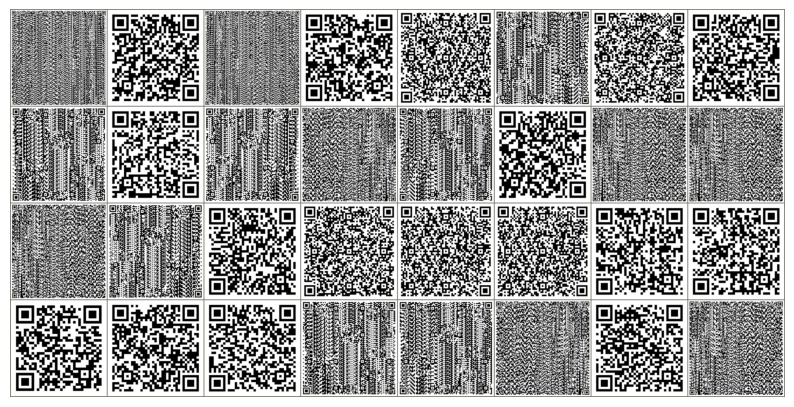

In [8]:
# Function to display images
def imshow(img):
    img = img.numpy().transpose((1, 2, 0))
    # Unnormalize
    mean = np.array([0.485, 0.456, 0.406])
    std  = np.array([0.229, 0.224, 0.225])
    img  = std * img + mean
    img  = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.axis('off')

# Get a batch of training data
images, labels = next(iter(train_loader))

# Make a grid from batch
out = utils.make_grid(images)

# Display images
plt.figure(figsize=(10, 10))
imshow(out)
plt.show()

In [9]:
# Load pre-trained ResNet18 model
model = models.resnet18(pretrained=True)

# Modify the final layer
num_ftrs = model.fc.in_features
num_classes = len(classes)
model.fc = nn.Linear(num_ftrs, num_classes)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 187MB/s]


In [10]:
# Move model to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [11]:
# Number of epochs
num_epochs = 60

# Training loop with progress bars
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_correct = 0
    total_samples = 0

    # Wrap the train_loader with tqdm for a progress bar
    pbar = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{num_epochs}]")
    for images, labels in pbar:
        images = images.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        # Update running loss
        running_loss += loss.item() * images.size(0)

        # Calculate accuracy within the batch
        _, preds = torch.max(outputs, 1)
        total_correct += torch.sum(preds == labels.data)
        total_samples += labels.size(0)

        # Update progress bar description
        pbar.set_postfix({
            'loss': f'{loss.item():.4f}',
            'acc': f'{(total_correct/total_samples*100):.2f}%'
        })

    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = total_correct.double() / len(train_dataset)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}')

Epoch [1/60]: 100%|██████████| 18/18 [00:08<00:00,  2.24it/s, loss=0.6924, acc=52.50%]


Epoch [1/60], Loss: 0.9423, Accuracy: 0.5250


Epoch [2/60]: 100%|██████████| 18/18 [00:05<00:00,  3.33it/s, loss=0.4138, acc=66.07%]


Epoch [2/60], Loss: 0.5387, Accuracy: 0.6607


Epoch [3/60]: 100%|██████████| 18/18 [00:07<00:00,  2.45it/s, loss=0.4290, acc=68.21%]


Epoch [3/60], Loss: 0.5153, Accuracy: 0.6821


Epoch [4/60]: 100%|██████████| 18/18 [00:05<00:00,  3.24it/s, loss=0.5040, acc=67.32%]


Epoch [4/60], Loss: 0.4752, Accuracy: 0.6732


Epoch [5/60]: 100%|██████████| 18/18 [00:07<00:00,  2.48it/s, loss=0.2979, acc=66.96%]


Epoch [5/60], Loss: 0.5160, Accuracy: 0.6696


Epoch [6/60]: 100%|██████████| 18/18 [00:05<00:00,  3.30it/s, loss=0.3493, acc=69.11%]


Epoch [6/60], Loss: 0.4466, Accuracy: 0.6911


Epoch [7/60]: 100%|██████████| 18/18 [00:06<00:00,  2.97it/s, loss=0.4891, acc=71.96%]


Epoch [7/60], Loss: 0.4083, Accuracy: 0.7196


Epoch [8/60]: 100%|██████████| 18/18 [00:06<00:00,  2.70it/s, loss=0.3931, acc=71.79%]


Epoch [8/60], Loss: 0.4193, Accuracy: 0.7179


Epoch [9/60]: 100%|██████████| 18/18 [00:05<00:00,  3.36it/s, loss=0.4195, acc=67.86%]


Epoch [9/60], Loss: 0.4829, Accuracy: 0.6786


Epoch [10/60]: 100%|██████████| 18/18 [00:07<00:00,  2.42it/s, loss=1.3825, acc=65.54%]


Epoch [10/60], Loss: 0.5337, Accuracy: 0.6554


Epoch [11/60]: 100%|██████████| 18/18 [00:05<00:00,  3.22it/s, loss=0.4672, acc=67.68%]


Epoch [11/60], Loss: 0.5029, Accuracy: 0.6768


Epoch [12/60]: 100%|██████████| 18/18 [00:06<00:00,  2.60it/s, loss=0.5745, acc=70.18%]


Epoch [12/60], Loss: 0.4215, Accuracy: 0.7018


Epoch [13/60]: 100%|██████████| 18/18 [00:05<00:00,  3.24it/s, loss=0.3382, acc=68.57%]


Epoch [13/60], Loss: 0.4128, Accuracy: 0.6857


Epoch [14/60]: 100%|██████████| 18/18 [00:05<00:00,  3.14it/s, loss=0.4280, acc=70.00%]


Epoch [14/60], Loss: 0.4043, Accuracy: 0.7000


Epoch [15/60]: 100%|██████████| 18/18 [00:06<00:00,  2.59it/s, loss=0.3602, acc=69.82%]


Epoch [15/60], Loss: 0.4078, Accuracy: 0.6982


Epoch [16/60]: 100%|██████████| 18/18 [00:05<00:00,  3.31it/s, loss=0.3523, acc=71.61%]


Epoch [16/60], Loss: 0.4050, Accuracy: 0.7161


Epoch [17/60]: 100%|██████████| 18/18 [00:09<00:00,  1.89it/s, loss=0.5044, acc=74.29%]


Epoch [17/60], Loss: 0.3961, Accuracy: 0.7429


Epoch [18/60]: 100%|██████████| 18/18 [00:06<00:00,  3.00it/s, loss=0.5193, acc=72.50%]


Epoch [18/60], Loss: 0.4041, Accuracy: 0.7250


Epoch [19/60]: 100%|██████████| 18/18 [00:07<00:00,  2.41it/s, loss=0.5102, acc=73.04%]


Epoch [19/60], Loss: 0.3933, Accuracy: 0.7304


Epoch [20/60]: 100%|██████████| 18/18 [00:05<00:00,  3.32it/s, loss=0.3531, acc=73.39%]


Epoch [20/60], Loss: 0.3927, Accuracy: 0.7339


Epoch [21/60]: 100%|██████████| 18/18 [00:06<00:00,  2.67it/s, loss=0.4329, acc=73.57%]


Epoch [21/60], Loss: 0.3894, Accuracy: 0.7357


Epoch [22/60]: 100%|██████████| 18/18 [00:05<00:00,  3.17it/s, loss=0.4310, acc=74.46%]


Epoch [22/60], Loss: 0.3814, Accuracy: 0.7446


Epoch [23/60]: 100%|██████████| 18/18 [00:05<00:00,  3.01it/s, loss=0.4218, acc=74.11%]


Epoch [23/60], Loss: 0.3837, Accuracy: 0.7411


Epoch [24/60]: 100%|██████████| 18/18 [00:08<00:00,  2.14it/s, loss=0.4004, acc=75.18%]


Epoch [24/60], Loss: 0.3762, Accuracy: 0.7518


Epoch [25/60]: 100%|██████████| 18/18 [00:05<00:00,  3.08it/s, loss=0.4535, acc=76.96%]


Epoch [25/60], Loss: 0.3704, Accuracy: 0.7696


Epoch [26/60]: 100%|██████████| 18/18 [00:06<00:00,  2.62it/s, loss=0.8046, acc=77.50%]


Epoch [26/60], Loss: 0.3624, Accuracy: 0.7750


Epoch [27/60]: 100%|██████████| 18/18 [00:05<00:00,  3.25it/s, loss=0.4807, acc=73.04%]


Epoch [27/60], Loss: 0.4224, Accuracy: 0.7304


Epoch [28/60]: 100%|██████████| 18/18 [00:07<00:00,  2.52it/s, loss=0.5576, acc=71.25%]


Epoch [28/60], Loss: 0.4909, Accuracy: 0.7125


Epoch [29/60]: 100%|██████████| 18/18 [00:05<00:00,  3.30it/s, loss=0.2468, acc=74.64%]


Epoch [29/60], Loss: 0.4009, Accuracy: 0.7464


Epoch [30/60]: 100%|██████████| 18/18 [00:06<00:00,  2.72it/s, loss=0.3931, acc=75.00%]


Epoch [30/60], Loss: 0.4074, Accuracy: 0.7500


Epoch [31/60]: 100%|██████████| 18/18 [00:05<00:00,  3.22it/s, loss=0.3150, acc=73.39%]


Epoch [31/60], Loss: 0.4225, Accuracy: 0.7339


Epoch [32/60]: 100%|██████████| 18/18 [00:05<00:00,  3.12it/s, loss=0.3707, acc=75.89%]


Epoch [32/60], Loss: 0.3616, Accuracy: 0.7589


Epoch [33/60]: 100%|██████████| 18/18 [00:06<00:00,  2.61it/s, loss=0.3290, acc=75.18%]


Epoch [33/60], Loss: 0.3841, Accuracy: 0.7518


Epoch [34/60]: 100%|██████████| 18/18 [00:05<00:00,  3.31it/s, loss=0.3811, acc=77.50%]


Epoch [34/60], Loss: 0.3646, Accuracy: 0.7750


Epoch [35/60]: 100%|██████████| 18/18 [00:07<00:00,  2.52it/s, loss=0.3073, acc=78.75%]


Epoch [35/60], Loss: 0.3549, Accuracy: 0.7875


Epoch [36/60]: 100%|██████████| 18/18 [00:05<00:00,  3.26it/s, loss=0.3088, acc=78.57%]


Epoch [36/60], Loss: 0.3276, Accuracy: 0.7857


Epoch [37/60]: 100%|██████████| 18/18 [00:06<00:00,  2.60it/s, loss=0.3337, acc=82.32%]


Epoch [37/60], Loss: 0.3132, Accuracy: 0.8232


Epoch [38/60]: 100%|██████████| 18/18 [00:05<00:00,  3.23it/s, loss=0.3078, acc=79.46%]


Epoch [38/60], Loss: 0.3276, Accuracy: 0.7946


Epoch [39/60]: 100%|██████████| 18/18 [00:05<00:00,  3.04it/s, loss=0.1239, acc=83.39%]


Epoch [39/60], Loss: 0.2815, Accuracy: 0.8339


Epoch [40/60]: 100%|██████████| 18/18 [00:07<00:00,  2.53it/s, loss=0.2087, acc=81.96%]


Epoch [40/60], Loss: 0.2919, Accuracy: 0.8196


Epoch [41/60]: 100%|██████████| 18/18 [00:05<00:00,  3.32it/s, loss=0.3711, acc=80.89%]


Epoch [41/60], Loss: 0.2711, Accuracy: 0.8089


Epoch [42/60]: 100%|██████████| 18/18 [00:07<00:00,  2.42it/s, loss=0.2132, acc=84.82%]


Epoch [42/60], Loss: 0.2462, Accuracy: 0.8482


Epoch [43/60]: 100%|██████████| 18/18 [00:05<00:00,  3.26it/s, loss=0.1147, acc=83.04%]


Epoch [43/60], Loss: 0.2631, Accuracy: 0.8304


Epoch [44/60]: 100%|██████████| 18/18 [00:07<00:00,  2.56it/s, loss=0.2336, acc=81.79%]


Epoch [44/60], Loss: 0.3095, Accuracy: 0.8179


Epoch [45/60]: 100%|██████████| 18/18 [00:05<00:00,  3.25it/s, loss=0.2283, acc=84.64%]


Epoch [45/60], Loss: 0.2791, Accuracy: 0.8464


Epoch [46/60]: 100%|██████████| 18/18 [00:05<00:00,  3.09it/s, loss=0.3051, acc=80.89%]


Epoch [46/60], Loss: 0.2886, Accuracy: 0.8089


Epoch [47/60]: 100%|██████████| 18/18 [00:06<00:00,  2.61it/s, loss=0.2884, acc=81.79%]


Epoch [47/60], Loss: 0.2700, Accuracy: 0.8179


Epoch [48/60]: 100%|██████████| 18/18 [00:05<00:00,  3.38it/s, loss=0.2335, acc=82.50%]


Epoch [48/60], Loss: 0.2743, Accuracy: 0.8250


Epoch [49/60]: 100%|██████████| 18/18 [00:07<00:00,  2.43it/s, loss=0.1142, acc=84.64%]


Epoch [49/60], Loss: 0.2701, Accuracy: 0.8464


Epoch [50/60]: 100%|██████████| 18/18 [00:05<00:00,  3.30it/s, loss=0.2871, acc=83.57%]


Epoch [50/60], Loss: 0.2976, Accuracy: 0.8357


Epoch [51/60]: 100%|██████████| 18/18 [00:07<00:00,  2.51it/s, loss=0.1219, acc=81.79%]


Epoch [51/60], Loss: 0.2664, Accuracy: 0.8179


Epoch [52/60]: 100%|██████████| 18/18 [00:05<00:00,  3.21it/s, loss=0.4994, acc=83.93%]


Epoch [52/60], Loss: 0.2542, Accuracy: 0.8393


Epoch [53/60]: 100%|██████████| 18/18 [00:06<00:00,  2.98it/s, loss=0.1178, acc=84.64%]


Epoch [53/60], Loss: 0.2678, Accuracy: 0.8464


Epoch [54/60]: 100%|██████████| 18/18 [00:06<00:00,  2.60it/s, loss=0.1432, acc=84.11%]


Epoch [54/60], Loss: 0.2354, Accuracy: 0.8411


Epoch [55/60]: 100%|██████████| 18/18 [00:05<00:00,  3.22it/s, loss=0.4896, acc=85.36%]


Epoch [55/60], Loss: 0.2451, Accuracy: 0.8536


Epoch [56/60]: 100%|██████████| 18/18 [00:07<00:00,  2.32it/s, loss=0.2461, acc=82.14%]


Epoch [56/60], Loss: 0.3328, Accuracy: 0.8214


Epoch [57/60]: 100%|██████████| 18/18 [00:06<00:00,  2.60it/s, loss=0.2825, acc=83.04%]


Epoch [57/60], Loss: 0.3072, Accuracy: 0.8304


Epoch [58/60]: 100%|██████████| 18/18 [00:07<00:00,  2.43it/s, loss=0.2397, acc=82.86%]


Epoch [58/60], Loss: 0.2783, Accuracy: 0.8286


Epoch [59/60]: 100%|██████████| 18/18 [00:05<00:00,  3.29it/s, loss=0.2521, acc=85.36%]


Epoch [59/60], Loss: 0.2481, Accuracy: 0.8536


Epoch [60/60]: 100%|██████████| 18/18 [00:06<00:00,  2.61it/s, loss=0.2981, acc=85.36%]

Epoch [60/60], Loss: 0.2484, Accuracy: 0.8536


Accuracy on test set: 0.8214
Classification Report:
              precision    recall  f1-score   support

      benign       0.94      0.69      0.79        70
   malicious       0.75      0.96      0.84        70

    accuracy                           0.82       140
   macro avg       0.85      0.82      0.82       140
weighted avg       0.85      0.82      0.82       140

Confusion Matrix:
[[48 22]
 [ 3 67]]


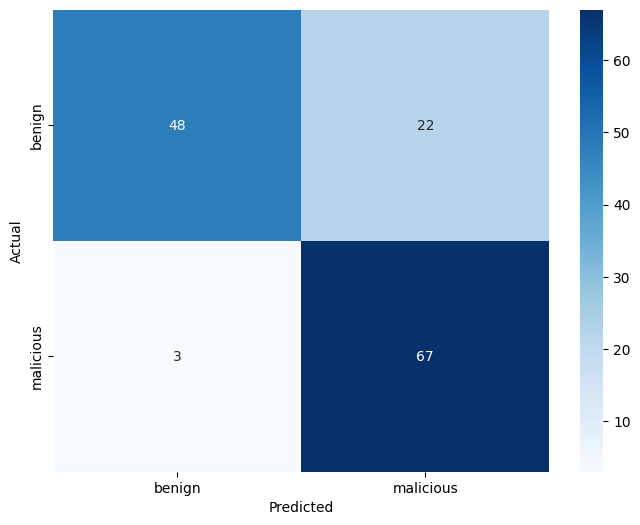

In [12]:
# Evaluate the model
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        _, preds = torch.max(outputs, 1)

        all_preds.extend(preds.cpu().numpy())


        all_labels.extend(labels.cpu().numpy())

# Compute accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Accuracy on test set: {accuracy:.4f}')

# Classification report
print('Classification Report:')
print(classification_report(all_labels, all_preds, target_names=classes))

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print('Confusion Matrix:')
print(cm)

# Plot confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=classes, yticklabels=classes)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [13]:
# Save the model
model_save_path = 'qr_code_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f'Model saved to {model_save_path}')

Model saved to qr_code_model.pth


In [14]:
!apt-get install -y libzbar0

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript gsfonts imagemagick-6-common
  libdjvulibre-text libdjvulibre21 libfftw3-double3 libgs9 libgs9-common libidn12 libijs-0.35
  libjbig2dec0 libjxr-tools libjxr0 liblqr-1-0 libmagickcore-6.q16-6 libmagickcore-6.q16-6-extra
  libmagickwand-6.q16-6 libv4l-0 libv4lconvert0 libwmflite-0.2-7 poppler-data
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre ghostscript-x libfftw3-bin
  libfftw3-dev inkscape poppler-utils fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-gothic fonts-arphic-ukai fonts-arphic-uming fonts-nanum
The following NEW packages will be installed:
  fonts-droid-fallback fonts-noto-mono fonts-urw-base35 ghostscript gsfonts imagemagick-6-common
  libdjvulibre-text libdjvulibre21 libfftw3-doub

In [15]:
!pip install pyzbar

Predicted label of QR code: benign
Decoded QR Code Link: 416298    http://www.mydocomo-smt-contact.com/
Name: url, dtype: object


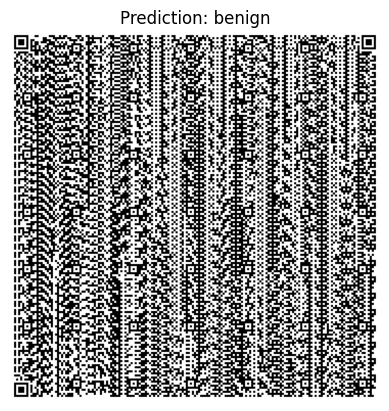

In [26]:
import cv2
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import warnings
from pyzbar.pyzbar import decode

# Ignore all warnings
warnings.filterwarnings("ignore")

# Load the saved model
def load_model(model_path, model):
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

# Preprocess the input image
def preprocess_image(image_path):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize the image
        transforms.ToTensor(),          # Convert the image to tensor
        transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize
    ])

    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Function to predict if the QR code is benign or malicious
def predict(image_path, model, device, classes):
    image = preprocess_image(image_path).to(device)

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)

    predicted_label = classes[predicted.item()]
    return predicted_label

# Function to decode the QR code
def decode_qr(image_path):
    img = cv2.imread(image_path)
    decoded_objects = decode(img)
    if decoded_objects:
        return decoded_objects[0].data.decode('utf-8')
    return None

# Function to display the input image and prediction
def display_image(image_path, prediction):
    image = Image.open(image_path)
    plt.imshow(image)
    plt.axis('off')
    plt.title(f'Prediction: {prediction}')
    plt.show()

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Classes for prediction
classes = {
    0: "benign",
    1: "malicious"
}

# Load your model (define your model architecture beforehand)
model = load_model('/content/qr_code_model.pth', model).to(device)

# Provide the path to the input QR code image
image_path = '/content/Multi-version QR codes/Test/malicious/malicious_version_40_416298.png'

# Predict the nature of the QR code
predicted_label = predict(image_path, model, device, classes)

# Display the prediction result
print(f'Predicted label of QR code: {predicted_label}')

# If benign, decode and open the QR code link
if predicted_label == "benign":
    link = decode_qr(image_path)
    if link:
        print(f'Decoded QR Code Link: {link}')
        # Here you can open the link in a web browser if desired
    else:
        print("No QR code could be decoded from the image.")
else:
    print("Warning: The QR code is classified as malicious!")

# Display the input image with the prediction
display_image(image_path, predicted_label)

In [46]:
!pip install gradio

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.6/50.6 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.7/56.7 MB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.8/319.8 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.0/78.0 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 447.4/447.4 kB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 144.5/144.5 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.0/11.0 MB 112.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.3/73.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/

In [47]:
import cv2
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import warnings
from pyzbar.pyzbar import decode
import gradio as gr

# Ignore all warnings
warnings.filterwarnings("ignore")

# Load the saved model
def load_model(model_path, model):
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

# Preprocess the input image
def preprocess_image(image):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),  # Resize the image
        transforms.ToTensor(),          # Convert the image to tensor
        transforms.Normalize(mean=[0.5], std=[0.5])  # Normalize
    ])

    image = image.convert('RGB')  # Convert to RGB for consistency
    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Function to predict if the QR code is benign or malicious
def predict(image, model, device, classes):
    image = preprocess_image(image).to(device)

    with torch.no_grad():
        outputs = model(image)
        _, predicted = torch.max(outputs, 1)

    predicted_label = classes[predicted.item()]
    return predicted_label

# Function to decode the QR code from a PIL image
def decode_qr_pil(image):
    # Convert PIL image to OpenCV format
    img = np.array(image)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)

    # Decode QR code using pyzbar
    decoded_objects = decode(img)
    if decoded_objects:
        return decoded_objects[0].data.decode('utf-8')
    return None

# Define a Gradio function for the QR code prediction
def gradio_interface(image):
    # Predict the nature of the QR code
    predicted_label = predict(image, model, device, classes)

    # If benign, decode and display the QR code link
    if predicted_label == "benign":
        link = decode_qr_pil(image)  # Use the PIL image decoder
        if link:
            result = f'<span style="font-size: 24px;"><strong>Predicted label of QR code:</strong> {predicted_label}<br>Decoded QR Code Link: <a href="{link}" target="_blank">{link}</a></span>'
        else:
            result = f'<span style="font-size: 24px;"><strong>Predicted label of QR code:</strong> {predicted_label}<br>No QR code could be decoded from the image.</span>'
    else:
        result = f'<span style="font-size: 24px; color: red;"><strong>Warning:</strong> The QR code is classified as malicious!</span>'

    return result

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Classes for prediction
classes = {
    0: "benign",
    1: "malicious"
}

# Load your model (replace this with your actual model architecture and path)
# Assuming you have defined the 'model' architecture beforehand
model = load_model('/content/qr_code_model.pth', model).to(device)

# Gradio interface definition
gr_interface = gr.Interface(
    fn=gradio_interface,
    inputs=gr.Image(type="pil"),  # Use PIL images for direct processing
    outputs=gr.HTML(),  # Change output type to HTML for clickable links
    title="QR Code Prediction System",
    description="Upload a QR code image to predict whether it's benign or malicious."
)

# Launch Gradio app
gr_interface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://d0b9bc739a5e4a0917.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [40]:
import requests

# Function to check URL using VirusTotal API and display flags
def check_url_with_virustotal(api_key, url_to_check):
    api_url = "https://www.virustotal.com/vtapi/v2/url/report"
    params = {'apikey': api_key, 'resource': url_to_check}
    response = requests.get(api_url, params=params)

    # Debugging: Log the API response for analysis
    print("API Response Status Code:", response.status_code)
    print("API Response Content:", response.text)  # Log the raw response

    if response.status_code == 200:
        result = response.json()
        if isinstance(result, list):
            print("Unexpected response format from VirusTotal. Please check the URL.")
            return
        if result.get('response_code') == 1:
            # Check if the URL is flagged as malicious
            if result.get('positives', 0) > 0:
                print(f"Malicious URL detected by VirusTotal! ({result['positives']} engines flagged this URL)\n")
                print("Engines that flagged the URL as malicious:")
                for engine, details in result['scans'].items():
                    if details['detected']:
                        print(f"- {engine}: {details['result']}")
                return "Malicious URL detection completed."
            else:
                return "URL is safe according to VirusTotal."
        else:
            return "URL not found in VirusTotal database."
    else:
        return f"VirusTotal API error: {response.status_code}, {response.text}"

# Main function to handle URL input
def main():
    url = input("Enter the URL to check: ").strip()

    if url:
        # Replace this with your actual VirusTotal API key
        VIRUSTOTAL_API_KEY = "85d6bc05eb6de996d360c0d967ab2ecd39d0b78cfa9ec2f88f6ec62a74a5298e"  # Replace with your actual key

        # Check with VirusTotal
        virustotal_result = check_url_with_virustotal(VIRUSTOTAL_API_KEY, url)
        print(virustotal_result)
    else:
        print("No valid URL provided.")

# Run the main function
main()


Enter the URL to check: http://fb.com.accounts.login.userid.343441.fbsbk.com/
API Response Status Code: 200
API Response Content: {"filescan_id":null,"permalink":"https://www.virustotal.com/gui/url/f0778e4aef6a3946b9eaf8efc71b6fe6f4be5708f593f3ffb3ac66c298a7a2f2/detection/u-f0778e4aef6a3946b9eaf8efc71b6fe6f4be5708f593f3ffb3ac66c298a7a2f2-1727038196","positives":8,"resource":"http://fb.com.accounts.login.userid.343441.fbsbk.com/","response_code":1,"scan_date":"2024-09-22 20:49:56","scan_id":"f0778e4aef6a3946b9eaf8efc71b6fe6f4be5708f593f3ffb3ac66c298a7a2f2-1727038196","scans":{"0xSI_f33d":{"detected":false,"result":"unrated site"},"ADMINUSLabs":{"detected":false,"result":"clean site"},"AILabs (MONITORAPP)":{"detected":false,"result":"clean site"},"Abusix":{"detected":false,"result":"clean site"},"Acronis":{"detected":false,"result":"clean site"},"AlienVault":{"detected":false,"result":"clean site"},"AlphaSOC":{"detected":false,"result":"unrated site"},"Antiy-AVL":{"detected":true,"result

In [49]:
import requests
import gradio as gr

# Function to check URL using VirusTotal API and display flags
def check_url_with_virustotal(api_key, url_to_check):
    api_url = "https://www.virustotal.com/vtapi/v2/url/report"
    params = {'apikey': api_key, 'resource': url_to_check}
    response = requests.get(api_url, params=params)

    # Debugging: Log the API response for analysis
    print("API Response Status Code:", response.status_code)
    print("API Response Content:", response.text)  # Log the raw response

    if response.status_code == 200:
        result = response.json()
        if isinstance(result, list):
            return "Unexpected response format from VirusTotal. Please check the URL."
        if result.get('response_code') == 1:
            # Check if the URL is flagged as malicious
            if result.get('positives', 0) > 0:
                response_message = f"Malicious URL detected by VirusTotal! ({result['positives']} engines flagged this URL)<br>"
                response_message += "<strong style='color: red;'>Engines that flagged the URL as malicious:</strong><br>"
                for engine, details in result['scans'].items():
                    if details['detected']:
                        response_message += f"- {engine}: {details['result']}<br>"
                return f"<div style='color: red; font-weight: bold;'>{response_message}</div>"
            else:
                return "<div style='color: green; font-weight: bold;'>URL is safe according to VirusTotal.</div>"
        else:
            return "<div style='color: orange; font-weight: bold;'>URL not found in VirusTotal database.</div>"
    else:
        return f"<div style='color: orange; font-weight: bold;'>VirusTotal API error: {response.status_code}, {response.text}</div>"

# Gradio interface function
def gradio_interface(url):
    if url:
        # Replace this with your actual VirusTotal API key
        VIRUSTOTAL_API_KEY = "85d6bc05eb6de996d360c0d967ab2ecd39d0b78cfa9ec2f88f6ec62a74a5298e"  # Replace with your actual key

        # Check with VirusTotal
        result = check_url_with_virustotal(VIRUSTOTAL_API_KEY, url)
        return f"<pre>{result}</pre>"  # Keep the preformatted style for structure
    else:
        return "<div style='color: orange; font-weight: bold;'>No valid URL provided.</div>"

# Gradio interface definition
gr_interface = gr.Interface(
    fn=gradio_interface,
    inputs=gr.Textbox(label="Enter URL to Check"),
    outputs=gr.HTML(),
    title="VirusTotal URL Checker",
    description="Input a URL to check if it's safe or malicious using VirusTotal."
)

# Launch Gradio app
gr_interface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://654b323ac25413e9a2.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
